# 2-5. 프로젝트: SentencePiece 사용하기

### [루브릭]
1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?
    - 코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?
    

2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?
    - SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.


3. SentencePiece의 성능을 다각도로 비교분석하였는가?
    - SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.

### [학습과정]
1. SentencePiece 설치하기
2. SentencePiece 모델 학습
3. Tokenizer 함수 작성
4. 네이버 영화리뷰 감정분석 문제에 SentencePiece 적용해 보기

### [결론 및 회고]

## 1. SentencePiece 설치하기

 pip install sentencepiece

## 2. SentencePiece 모델 학습하기



In [15]:
import os

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd

%matplotlib inline

In [5]:
import os
path_to_file = os.getenv('HOME') + '/aiffel/NLP01_MakeDictionary/data/korean-english-park.train.ko'

with open(path_to_file, 'r') as f:
    raw = f.read().splitlines()
    
print('Data Size', len(raw))

print("Example:")
for sen in raw[0:100][::20]:print(">>",sen)

Data Size 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


Data Size: 77591
문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 64


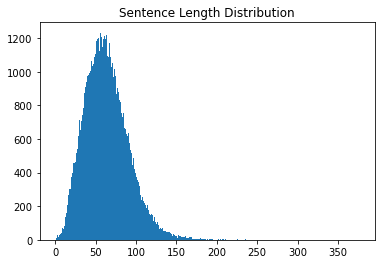

In [8]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

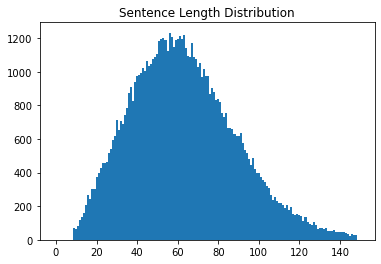

In [9]:
max_len = 150
min_len = 10

# 길이 조건에 맞는 문장만 선택합니다
filtered_corpus = [s for s in cleaned_corpus if (len(s)<max_len)&(len(s) >= min_len)]

# 분포도를 다시 그려봅니다
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1
    
plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [10]:
import sentencepiece as spm

temp_file = os.getenv('HOME') + '/aiffel/NLP01_MakeDictionary/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:
        f.write(str(row) + '\n')
        
spm.SentencePieceTrainer.Train(
'--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size))

#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

-rw-r--r-- 1 ssac18 ssac18 376905  4월  7 10:21 korean_spm.model
-rw-r--r-- 1 ssac18 ssac18 146388  4월  7 10:21 korean_spm.vocab


In [11]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1244, 11, 306, 7, 3599, 11, 286, 38, 3]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


In [12]:
def sp_tokenize(s, corpus):
    
    tensor = []
    
    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))
        
    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()
        
    word_index = {}
    index_word = {}
    
    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]
        
        word_index.update({idx:word})
        index_word.update({word:idx})
        
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    return tensor, word_index, index_word

In [13]:
#sp_tokenize(s, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)

[[1949 5662    5    4 7975 1983    3    0    0    0    0    0    0    0]
 [ 107 1638  101    4    0  419   11    4   14    0 1969    3    3    3]]


* 네이버 영화리뷰 감정분석 코퍼스에 sentencepiece를 적용시킨 모델 학습하기

* 학습된 모델로 sp_tokenize() 메소드 구현하기

* 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정분석 모델을 재학습하기

* KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기

* (보너스) SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

* Word Vector는 활용할 필요가 없습니다. 활용이 가능하지도 않을 것입니다.

* 머지않아 SentencePiece와 BERT 등의 pretrained 모델을 함께 활용하는 태스크를 다루게 될 것입니다.

In [17]:
train_data = pd.read_table('~/aiffel/NLP01_MakeDictionary/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/NLP01_MakeDictionary/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=70000):
    train_data.drop_duplicates(subset=['document'], inplace=True) # 데이터 중복 제거
    train_data = train_data.dropna(how='any')          # 결측치 제거       
    test_data.drop_duplicates(subset=['document'], inplace=True) # 데이터 중복 제거
    test_data = test_data.dropna(how = 'any')          # 결측치 제거
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # stopwords 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # stopwords 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(70000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
    
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))
print(len(word_to_index))